In [2]:
import pandas as pd
import numpy as np
from atom import ATOMRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [16]:
df = pd.read_pickle('../data/model_data.pkl')
data = df.copy()

type_enc = {'event_type':{'Sale':0, 'OnlineSale':1}}
data = data.replace(type_enc)
data['event_type'] = data.event_type.astype('float')
data['year'] = data.start_date.dt.year.astype('float')
data['month'] = data.start_date.dt.month.astype('float')
dat = pd.get_dummies(data, prefix='loc', columns=['location'], dtype='float', drop_first=True)

dat = dat.drop(['consigner_information', 'start_date', 'end_date', 'lot_title', 'clean_description'], axis=1)

#print(dat.columns)
print(dat.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53903 entries, 0 to 54632
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   event_type                    53903 non-null  float64
 1   estimate_low                  53903 non-null  float64
 2   estimate_high                 53903 non-null  float64
 3   price_realised                53903 non-null  float64
 4   title_full                    53903 non-null  object 
 5   year                          53903 non-null  float64
 6   month                         53903 non-null  float64
 7   loc_Dubai                     53903 non-null  float64
 8   loc_Geneva                    53903 non-null  float64
 9   loc_Hong Kong                 53903 non-null  float64
 10  loc_London                    53903 non-null  float64
 11  loc_London (South Kensigton)  53903 non-null  float64
 12  loc_Milan                     53903 non-null  float64
 13  l

In [27]:
final_test = dat.copy().tail(5000)
to_split = dat.copy().head(len(dat)-5000)
text_col = pd.DataFrame(to_split['title_full'])
txt_X = text_col.to_numpy(copy=True)
ys = to_split['price_realised']
xs = to_split.drop('price_realised', axis=1)
X = xs.to_numpy(copy=True)
y = ys.to_numpy(copy=True)

# call atom pipeline
atom = ATOMRegressor(txt_X, y, test_size=0.2, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: regression.

Dataset stats ==================== >>
Shape: (48903, 2)
Memory: 8.50 MB
Scaled: False
Categorical features: 1 (100.0%)
Outlier values: 214 (0.3%)
Duplicate samples: 2163 (4.4%)
-------------------------------------
Train set size: 39123
Test set size: 9780



In [29]:
atom.textclean()

Cleaning the corpus...
 --> Decoding unicode characters to ascii.
 --> Converting text to lower case.
 --> Dropping 0 emails from 0 documents.
 --> Dropping 0 URL links from 0 documents.
 --> Dropping 0 HTML tags from 0 documents.
 --> Dropping 0 emojis from 0 documents.
 --> Dropping 79970 numbers from 36057 documents.
 --> Dropping punctuation from the text.


In [30]:
atom.tokenize()
atom.corpus[0]

Tokenizing the corpus...


[nltk_data] Downloading package punkt to /Users/Ty/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['a', 'charles', 'i', 'oak', 'joined', 'stool', 'early', '17th', 'century']

In [31]:
atom.normalize(stopwords="english", lemmatize=True)
atom.corpus[0]

Normalizing the corpus...


[nltk_data] Downloading package stopwords to /Users/Ty/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


 --> Dropping stopwords.


[nltk_data] Downloading package wordnet to /Users/Ty/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Ty/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /Users/Ty/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


 --> Applying lemmatization.


['charles', 'oak', 'join', 'stool', 'early', '17th', 'century']

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.


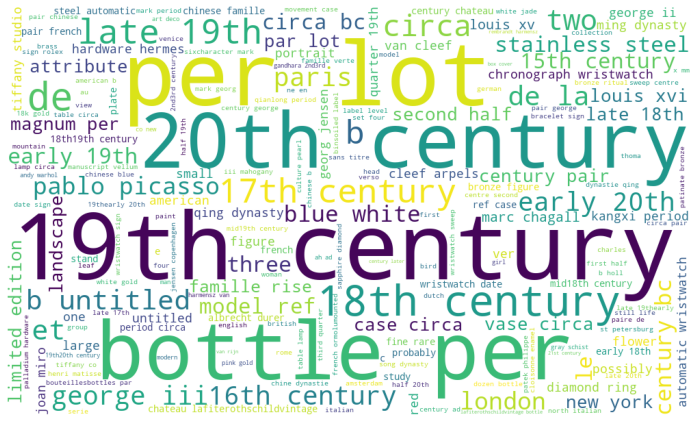

In [32]:
atom.plot_wordcloud()

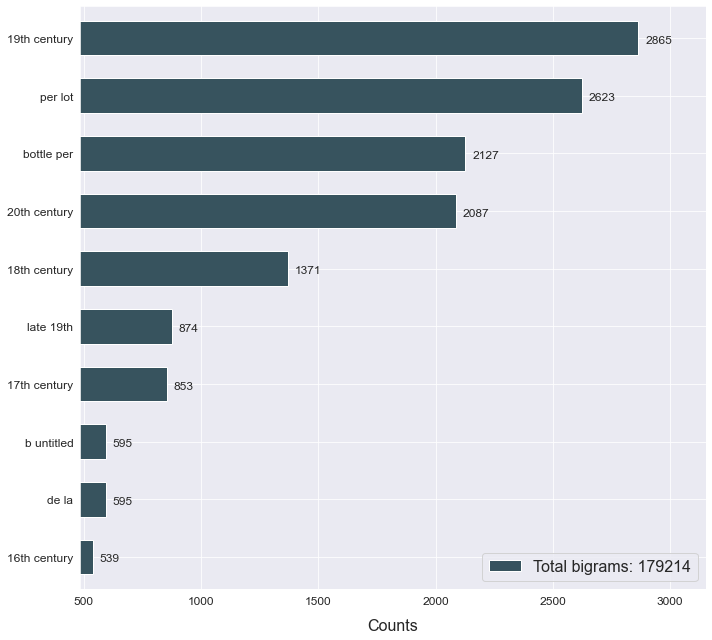

In [33]:
atom.plot_ngrams(2)

In [35]:
atom.tokenize(bigram_freq=500)

Tokenizing the corpus...
 --> Creating 3 bigrams on 3411 locations.


In [36]:
atom.vectorize(strategy="tfidf")
atom.shape

Fitting Vectorizer...
Vectorizing the corpus...


(48903, 40311)

In [39]:
atom.dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48903 entries, 0 to 48902
Columns: 40311 entries, 000a to target
dtypes: Sparse[float64, 0](40310), float64(1)
memory usage: 4.8 MB


In [48]:
atom.run(models="RF", metric="f1_weighted")


Training ========================= >>
Models: RF
Metric: f1_weighted


Results for Random Forest:
Fit ---------------------------------------------


pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



Exception encountered while running the RF model. Removing model from pipeline. 
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [49]:
atom.evaluate()

NotFittedError: This ATOMRegressor instance is not fitted yet. Call 'fit' or 'run' with appropriate arguments before using this estimator.

In [41]:
clean = atom.dataset
to_add = to_split.drop('title_full', axis=1)

# add preprocessed, non-text columns back to dataset
for col in list(to_add.columns):
    clean[col] = to_add[col]

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [46]:
y_vals = clean['target']
x_vals = clean.drop('target', axis=1)

xt, yt, xtest, ytest = train_test_split(x_vals, y_vals, test_size=0.25)

In [47]:
lr = LogisticRegression().fit(xt, yt)
preds = lr.predict(xtest)
acc = accuracy_score(ytest, preds)
print(acc)

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').